In [74]:
# --------------  Let's import the data --------------
# import yfinance as yf
# import pandas as pd

# stock = 'AMZN'
# years = ['2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']
# data_list = []

# for year in years:
#     end_of_year = str(int(year[:4]) + 1) + '-01-01'
#     data = yf.download(
#         tickers=[stock],
#         start=year,
#         end=end_of_year,
#         interval="1d"
#     )
#     data_list.append(data)

# # Concatenate data from different years into a single DataFrame
# amzn_data = pd.concat(data_list)

# # Save the combined data to a CSV file
# amzn_data.to_csv('AMZN_data_2012_to_2019.csv')

In [75]:
# --------------  We then format the train and test data --------------

import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Defie N the slicing window
N = 10

# Stock the date of the holidays for year 2012 to 2018 :
dates_list = [
    # Columbus Day (Second Monday in October)
    '2012-10-08', '2013-10-14', '2014-10-13', '2015-10-12', '2016-10-10', '2017-10-09', '2018-10-08',

    # Veteran's Day (November 11th)
    '2012-11-11', '2013-11-11', '2014-11-11', '2015-11-11', '2016-11-11', '2017-11-11', '2018-11-11',

    # Black Friday (Friday after Thanksgiving)
    '2012-11-23', '2013-11-29', '2014-11-28', '2015-11-27', '2016-11-25', '2017-11-24', '2018-11-23',

    # December 31st
    '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31'
]

# Define a list of holidays for 2019
holidays_2019 = [
    "2019-10-14",  # Columbus Day
    "2019-11-11",  # Veteran's Day
    "2019-11-29",  # Friday after Thanksgiving
    "2019-12-31",  # December 31
]


# Load the data from the CSV file
df = pd.read_csv('AMZN_data_2012_to_2019.csv')


# Keep only the "Date" and "Close" columns to limit the amount of data we feed the model
df = df[['Date', 'Volume']]


# Assuming 'Date' is in datetime format, if not, convert it first
df['Date'] = pd.to_datetime(df['Date'])


# Filter training data (6 first years)
start_date = '2012-01-01'
end_date = '2019-01-01'
train_data = df[(df['Date'] <= end_date)]


# Calculate the index to start the test data (N indices before the end date)
test_start_index = len(df[df['Date'] <= end_date]) - N


# Filter test data (2 last year of data)
test_data = df.iloc[test_start_index:]

#  ------- We normalize the data to help the NN converge :

# Initialize separate scalers for training and test data
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

train_data['Volume'] = scaler_train.fit_transform(train_data[['Volume']])
test_data['Volume'] = scaler_test.fit_transform(test_data[['Volume']])


# ------- We now format the train data into Input-Output Pairs :

input_sequences = []
targets = []

for date in dates_list:
    # retrieves date index
    indice_date = train_data[train_data['Date'] == date].index

    # Skip if the holiday is on a sunday and we have no data 
    if not indice_date.empty:
        indice_date = indice_date[0]
    else:
        continue  # Skip to the next iteration

    # 
    input_sequence = train_data['Volume'].iloc[indice_date-N:indice_date].values
    target = train_data['Volume'].iloc[indice_date]
    input_sequences.append(input_sequence)
    targets.append(target)


# Convert data into tensors:
input_tensors = torch.tensor(input_sequences, dtype=torch.float32)
target_tensors = torch.tensor(targets, dtype=torch.float32)


# --------- We now Create input sequences for the test data and convert them into tensor
test_input_sequences = []
test_data.to_csv('test_data.csv')
train_data.to_csv('train_data.csv')

for date in holidays_2019:
    # Retrieve date index
    indice_date = test_data[test_data['Date'] == date].index
    print("Date:", date)
    
    # Skip if the holiday is on a Sunday and we have no data
    if not indice_date.empty:
        indice_date = indice_date[0]
        print("Selected Indice Date:", indice_date)
    else:
        continue  # Skip to the next iteration

    # Debugging: Print the slicing indices
    start_index = max(0, indice_date - N)  # Ensure it doesn't go below 0
    end_index = indice_date
    print("Slicing indices:", start_index, end_index)

    # Select the 'Volume' values between the indices
    input_sequence = test_data['Volume'].iloc[start_index-1750:end_index-1750].values
    print(input_sequence)
    test_input_sequences.append(input_sequence)

    
test_input_tensors = torch.tensor(test_input_sequences, dtype=torch.float32)


Date: 2019-10-14
Selected Indice Date: 1957
Slicing indices: 1947 1957
[0.13820832 0.17267811 0.18965436 0.202751   0.12466494 0.09980406
 0.1301591  0.09108864 0.13276119 0.18604123]
Date: 2019-11-11
Selected Indice Date: 1977
Slicing indices: 1967 1977
[0.22161611 0.10938161 0.12290148 0.14890665 0.14962771 0.14817776
 0.07870523 0.09001489 0.13870993 0.09734305]
Date: 2019-11-29
Selected Indice Date: 1990
Slicing indices: 1980 1990
[0.10843326 0.23875696 0.15347598 0.10890352 0.14959636 0.13963477
 0.12522925 0.20416177 0.18025707 0.16806176]
Date: 2019-12-31
Selected Indice Date: 2011
Slicing indices: 2001 2011
[0.17743554 0.21656086 0.19359668 0.13884317 0.33462654 0.09836978
 0.         0.40160671 0.41580845 0.21893565]


/var/folders/w9/mnqyw1151sb3m7h0pdr46lz00000gn/T/ipykernel_27296/2618900172.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Volume'] = scaler_train.fit_transform(train_data[['Volume']])
/var/folders/w9/mnqyw1151sb3m7h0pdr46lz00000gn/T/ipykernel_27296/2618900172.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Volume'] = scaler_test.fit_transform(test_data[['Volume']])


In [76]:
# --------------  We create the NN model --------------
import torch.nn as nn

input_dim = N              # N = 30
hidden_dim = 60             # To be changed for better performances
output_dim = 1              # Forecasted price

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_4 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_5 = nn.Linear(hidden_dim, output_dim)
       
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = self.layer_2(x)  # Use linear activation
        x = torch.nn.functional.relu(self.layer_2(x))
        x = self.layer_3(x)  # Use linear activation
        x = torch.nn.functional.relu(self.layer_3(x))
        x = self.layer_4(x)  # Use linear activation
        x = torch.nn.functional.relu(self.layer_4(x))
        x = self.layer_5(x)  # Use linear activation
        
        return x
       
model = NeuralNetwork(input_dim, hidden_dim, output_dim)



In [77]:
#choosing the optimizer and the learning rate
learning_rate = 0.0005                                                   # Smaller learning rate to assure convergence 
loss_fn = nn.MSELoss()  # Use L1Loss for MAE

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      # Use an advanced optimizer like Adam



In [78]:
# ---------------------- Now we train the model ------------
batch_size = 2
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()
    print(epoch)
    
    for i in range(0, len(input_tensors), batch_size):
        inputs = input_tensors[i:i+batch_size]
        targets = target_tensors[i:i+batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = loss_fn(outputs, targets)


        # Backpropagation
        loss.backward()

        # Update the weights
        optimizer.step()
        
    # Append the loss value for the current epoch
    loss_values.append(loss.item())
    
print("Training Complete")
print(len(targets))


0
1
2
3


/Users/thedog/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/thedog/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Training Complete
1


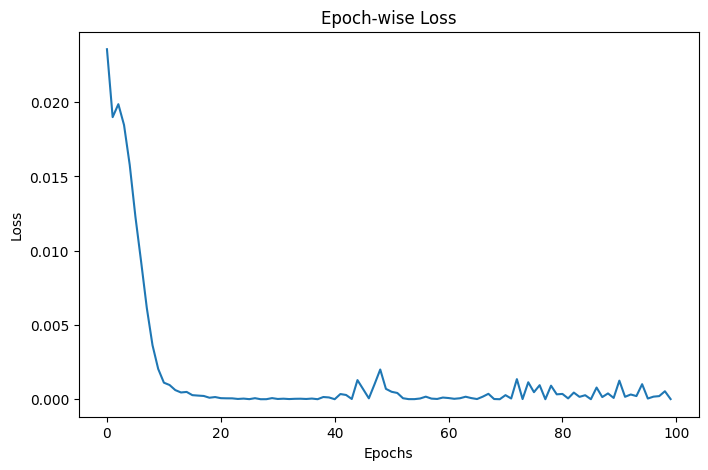

9.835300261329394e-06


In [79]:
# Generate step values based on the number of epochs
step = np.arange(num_epochs)

# Your existing code for plotting
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(step, np.array(loss_values))
plt.title("Epoch-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
print(loss_values[-1])

In [86]:

# -------------------- Now let's test our model on the first 2 months of 2019 

# Set the model in evaluation mode
model.eval()

# Create an empty list to store the model's predictions
test_predictions = []
# Iterate through the test input sequences
for input_sequence in test_input_tensors:
    # Perform inference
    with torch.no_grad():
        prediction = model(input_sequence)
    
    # Append the prediction to the list
    test_predictions.append(prediction.item())
test_predictions = scaler_test.inverse_transform(np.array(test_predictions).reshape(-1, 1))

print(test_predictions)

real_values = [0.08064111607492752,0.08344697860333883,0.08167567991221883,0.12737675366408027]
real_values = scaler_train.inverse_transform(np.array(real_values).reshape(-1, 1))
print(real_values)

# Assuming test_predictions and real_values are lists of the same length
mse_list = []

for i in range(len(test_predictions)):
    mse = mean_squared_error([real_values[i]], [test_predictions[i]])
    mse_list.append(mse)

print("MSE List for Each Day:", mse_list)

# # Convert the list of predictions to its original scale



[[63447681.26165866]
 [44124121.48660421]
 [56824429.47334051]
 [31987492.88505316]]
[[56575988.2906184 ]
 [57859485.21043969]
 [57049232.96496591]
 [77954457.93557489]]
MSE List for Each Day: [47220164288244.164, 188660216626055.56, 50536609846.970566, 2112961875955886.2]
